## Workflow for Example Notebook 1

Assessing the Envionrments Impact of COVID-19 in Venice

## Overview:
1. We download and plot the covid mobility data over the region of Veneto and extract the lowest value in activity
2. Using this a porxy for reduced activity, we download NASA nightlights to assess if we can see a change
3. We then check vessel density within the region
4. Visual assessment of impacts on water quality we use sentinel-2 imagery
5. Download water quality imagery 
6. Finally compare with water quality insitu timeseries

#### Permissions and Package Download

In [1]:
import concurrent.futures
import datetime as dt
from ipyleaflet import basemaps, Map, GeoJSON
import json
import requests as re
import matplotlib.pyplot as plt
import pprint
import time
import datetime
import csv
import requests
import numpy as np
import sys
import pandas as pd
# Configure plots for inline use in Jupyter Notebook
%matplotlib inline

In [2]:
from edc import check_compatibility
from xcube_geodb.core.geodb import GeoDBClient
geodb = GeoDBClient()
geodb.whoami

'geodb_edfb9926-6c9d-4be2-a6f0-aaef93b2a038'

In [3]:
import os
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
# Your client credentials
client_id = os.environ['SH_CLIENT_ID']
client_secret = os.environ['SH_CLIENT_SECRET']
# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)
# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)
# All requests using this session will have an access token automatically added
resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")
# Sentinel Hub
from sentinelhub import (MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, 
                         DataCollection, bbox_to_dimensions, DownloadRequest, SHConfig)

In [4]:
# Pass Sentinel Hub credentials to SHConfig
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

In [5]:
from edc import check_compatibility
from xcube_geodb.core.geodb import GeoDBClient
geodb = GeoDBClient()
geodb.whoami

'geodb_edfb9926-6c9d-4be2-a6f0-aaef93b2a038'

## Covid Mobility Data
We use the COVID Mobility data to relate lockdowns to changing behaviour in the region of Veneto, Italy. We use this data to estimate the times where the lockdown restrictions were at their highest and inturn relate this to activity and finaly water quality.

The Covid Mobility data covers the larger area of Veneto, which includes the region of Venice. Below we display the region using NUTS data:

In [6]:
import requests
# First let us get the area information of the country from the administratives zones
# You can find all the different NUTS levels, resolution here: https://gisco-services.ec.europa.eu/distribution/v2/nuts/nuts-2021-files.html

response = requests.get(
    "https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_10M_2021_4326_LEVL_2.geojson"
)

data = response.json()

# Now lets find the geometry information for one country
match = [x for x in data["features"] if x["properties"]["NUTS_ID"] == 'ITH3'][0]

In [7]:
import shapely.geometry
import IPython.display
IPython.display.GeoJSON(match)

<IPython.display.GeoJSON object>

In [8]:
# Download google mobilty dataset

url = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'

gfile = requests.get(url, allow_redirects=True)
open('gmobility_data.csv', 'wb').write(gfile.content)

1012285373

In [9]:
# Import the data as a pandas Dataset

mobility = pd.read_csv("gmobility_data.csv")
mobility['date'] =  pd.to_datetime(mobility['date'], infer_datetime_format=True)

/tmp/ipykernel_195/2432808316.py:3: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  mobility = pd.read_csv("gmobility_data.csv")


In [10]:
# Some preprocessing of the data

veneto = mobility.loc[(mobility['sub_region_1'] == "Veneto")]
veneto_ts = veneto.set_index('date') 

In [11]:
weekly_veneto = veneto_ts.resample('W').mean()

<AxesSubplot:xlabel='date'>

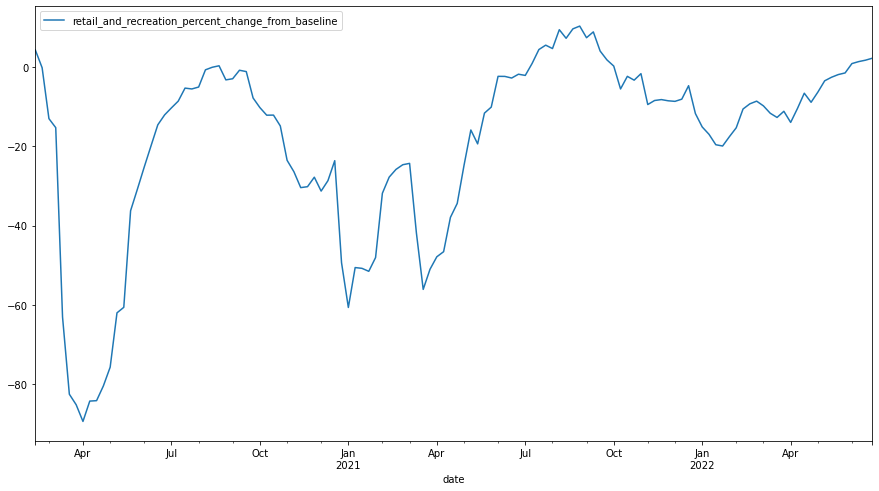

In [12]:
weekly_veneto.plot(y='retail_and_recreation_percent_change_from_baseline', figsize=(15,8))

In [13]:
# We output the date of the lowest value
weekly_veneto.retail_and_recreation_percent_change_from_baseline.idxmin()

Timestamp('2020-04-05 00:00:00', freq='W-SUN')

In [14]:
import geojson

def bbox(coord_list):
     box = []
     for i in (0,1):
         res = sorted(coord_list, key=lambda x:x[i])
         box.append((res[0][i],res[-1][i]))
     ret = f"({box[0][0]} {box[1][0]}, {box[0][1]} {box[1][1]})"
     return ret

# obviously you need to parse your json here

import geojson
import shapely.wkt

area = shapely.wkt.loads('POLYGON((12.174395 44.778037,12.196361 44.816998,12.085149 45.405263,12.426024 45.583514,13.153667 45.779148,13.603981 45.811687,13.804426 45.675662,13.823647 45.596962,13.626039 45.443008,13.549156 45.433376,13.626039 45.323461,13.713905 45.095238,13.78383 44.980605,13.830519 44.892158,13.8 44.5,12.234821 44.481556,12.06659 44.581469,12.174395 44.778037))')
gj_feat = geojson.Feature(geometry=area, properties={})

IPython.display.GeoJSON(gj_feat)

<IPython.display.GeoJSON object>

In [15]:
# we create a bounding box for the geojson 

line = bbox(list(geojson.utils.coords(gj_feat)))
print(line)

(12.06659 44.481556, 13.830519 45.811687)


In [16]:
adriatic = [
  12.06659,
  44.481556,
  13.830519,
  45.811687
]

In [17]:
#Set the resolution and create a sentinel hub bbox and size object

resolution = 100
adriatic_bbox = BBox(bbox=adriatic, crs=CRS.WGS84)
adriatic_size = bbox_to_dimensions(adriatic_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {adriatic_bbox} pixels')

Image shape at 100 m resolution: 12.06659,44.481556,13.830519,45.811687 pixels


In [18]:
import geojson
import shapely.wkt

area = shapely.wkt.loads('POLYGON((12.174395 44.778037,12.196361 44.816998,12.085149 45.405263,12.426024 45.583514,13.153667 45.779148,13.603981 45.811687,13.804426 45.675662,13.823647 45.596962,13.626039 45.443008,13.549156 45.433376,13.626039 45.323461,13.713905 45.095238,13.78383 44.980605,13.830519 44.892158,13.8 44.5,12.234821 44.481556,12.06659 44.581469,12.174395 44.778037))')
gj_feat = geojson.Feature(geometry=area, properties={})

In [19]:
# Define the plot_image function
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [20]:
# Aquire the vessel density data from the SH

In [21]:
evalscript_vessels = """
    //VERSION=3
    function setup() {
    return {
        input: [{
          bands: ["All", "dataMask"], // this sets which bands to use
        }],
        output: { // this defines the output image type
          bands: 4,
          sampleType: "UINT8"
        }
    };
}

function evaluatePixel(sample) {

  var arr = colorBlend(sample.All,    [0.5, 2, 5 , 10, 20 , 150],    
  [[0,155,143],[0,219,0],[255,252,0],[244,154,0],[208,19,0], [161,0,0] ]); 
  if (sample.dataMask==1)  arr.push(255);
  else arr.push(0);
  return arr;
}

    """

In [22]:
request_vessels_covid = SentinelHubRequest(
    evalscript=evalscript_vessels,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc('beee9b47-b1ab-4044-baa5-0958d3465f12'),
            time_interval=('2020-03-15', '2020-04-15'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=adriatic_bbox,
    size=adriatic_size,
    config=config
)

In [23]:
request_vessels_pre = SentinelHubRequest(
    evalscript=evalscript_vessels,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc('beee9b47-b1ab-4044-baa5-0958d3465f12'),
            time_interval=('2020-01-12', '2020-02-13'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=adriatic_bbox,
    size=adriatic_size,
    config=config
)

In [24]:
vessel_covid = request_vessels_covid.get_data()

Image type: uint8


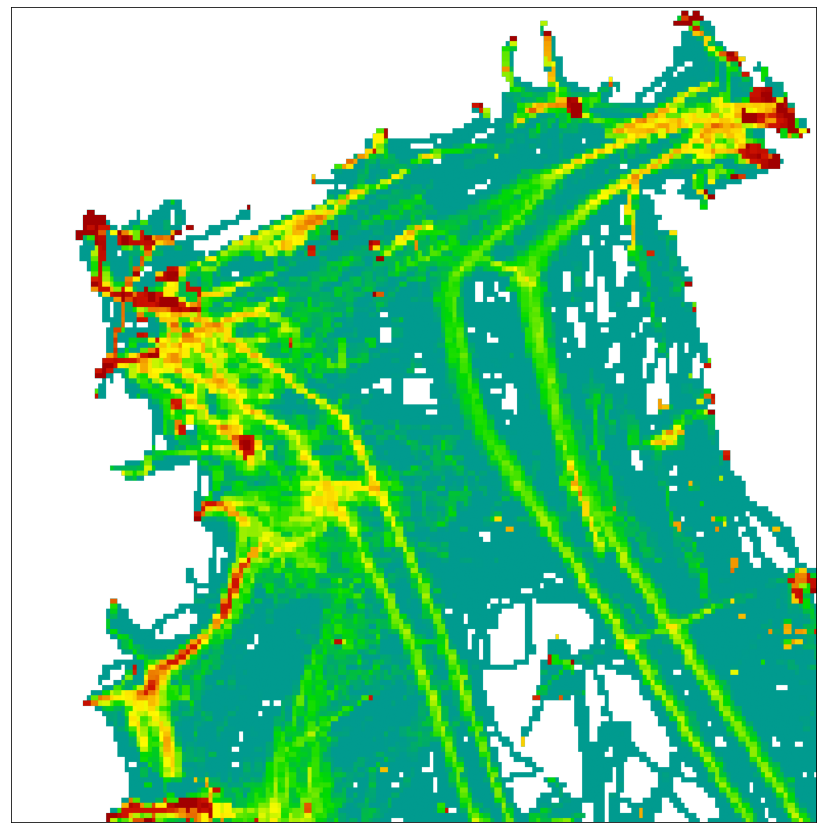

In [25]:
image = vessel_covid[0]
print(f'Image type: {image.dtype}')

# plot function
byoc_data = request_vessels_covid.get_data()
plot_image(byoc_data[0], factor=1 / 255)

In [26]:
vessel_pre = request_vessels_pre.get_data()

Image type: uint8


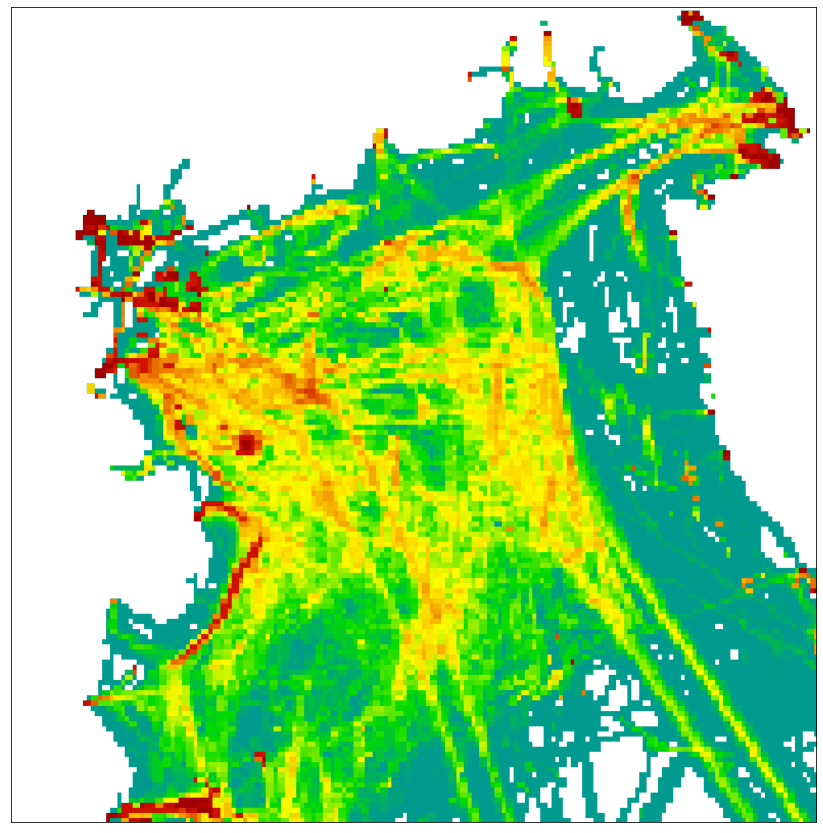

In [27]:
image = vessel_pre[0]
print(f'Image type: {image.dtype}')

# plot function
byoc_data = request_vessels_pre.get_data()
plot_image(byoc_data[0], factor=1 / 255)

In [28]:
## Exersise 1: Make a change map!


## Using the NASA API to retreive nightlights data

In [29]:
import requests as re
from ipyleaflet import Map, basemaps, basemap_to_tiles, TileLayer, SplitMapControl

STAC_ENDPOINT_URL = "https://staging-stac.delta-backend.xyz"
RASTER_ENDPOINT_URL = "https://staging-raster.delta-backend.xyz"

In [30]:
nightlights_collection_summary = re.get(f"{STAC_ENDPOINT_URL}/collections/nightlights-hd-monthly").json()
nightlights_collection_summary

{'id': 'nightlights-hd-monthly',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://staging-stac.delta-backend.xyz/collections/nightlights-hd-monthly/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.xyz/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.xyz/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.xyz/collections/nightlights-hd-monthly'}],
 'title': 'Black Marble High Definition Nightlights Monthly Dataset',
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2017-07-21T00:00:00Z',
     '2021-09-30T23:59:59Z']]}},
 'license': 'MIT',
 'summaries': {'datetime': ['2019-01-01T00:00:00Z', '2022-03-01T00:00:00Z'],
  'cog_default': {'max': 255, 'min': 0}},
 'description': 'The High Definition Nightlights dataset is processed to eliminate lig

In [31]:
rescale_values = nightlights_collection_summary["summaries"]["cog_default"]
rescale_values

{'max': 255, 'min': 0}

In [32]:
response_pre = re.post(
    f"{STAC_ENDPOINT_URL}/search", 
    json={
        "collections": ["nightlights-hd-monthly"],
        "query": {"datetime": {"eq":"2019-03-01T00:00:00"}},
        "limit": 100
    }
).json()
item_pre = response_pre["features"][0]

In [33]:
tiles_pre_covid = re.get(
    f"{RASTER_ENDPOINT_URL}/stac/tilejson.json?collection={item_pre['collection']}&item={item_pre['id']}&assets=cog_default&bidx=1&unscale=false&resampling=nearest&max_size=1024&rescale=0%2C255&colormap_name=viridis", 
).json()
tiles_pre_covid

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://staging-raster.delta-backend.xyz/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nightlights-hd-monthly&item=finalBMHD_ScaledVenice_201903&assets=cog_default&bidx=1&unscale=false&resampling=nearest&max_size=1024&rescale=0%2C255&colormap_name=viridis'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [11.7631744, 45.06062636, 12.79039608, 45.79310055],
 'center': [12.27678524, 45.426863455, 0]}

In [34]:
response_nasa_covid = re.post(
    f"{STAC_ENDPOINT_URL}/search", 
    json={
        "collections": ["nightlights-hd-monthly"],
        "query": {"datetime": {"eq":"2020-03-01T00:00:00"}},
        "limit": 100
    }
).json()
item_covid = response_nasa_covid["features"][0]

In [35]:
tiles_covid = re.get(
    f"{RASTER_ENDPOINT_URL}/stac/tilejson.json?collection={item_covid['collection']}&item={item_covid['id']}&assets=cog_default&bidx=1&unscale=false&resampling=nearest&max_size=1024&rescale=0%2C255&colormap_name=viridis", 
).json()
tiles_covid

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://staging-raster.delta-backend.xyz/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nightlights-hd-monthly&item=finalBMHD_ScaledVenice_202003&assets=cog_default&bidx=1&unscale=false&resampling=nearest&max_size=1024&rescale=0%2C255&colormap_name=viridis'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [11.7631744, 45.06062636, 12.79039608, 45.79310055],
 'center': [12.27678524, 45.426863455, 0]}

In [36]:
center = [45.438558, 12.333421]
zoom = 13

In [37]:
m = Map(center=center, zoom=zoom)
m

Map(center=[45.438558, 12.333421], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [38]:
left = TileLayer(url=tiles_pre_covid["tiles"][0])
right = TileLayer(url=tiles_covid["tiles"][0])

control = SplitMapControl(left_layer=left, right_layer=right)
m.add_control(control)

From this comparison we can see that the nighlights show a reduction in luminosity over the covid period.

### Retreiving imagery over the Island of Venice
Now we have identified the drop in activity due to the lockdown conditions we can retreive the sattellite images to see if there is a correstponding impact visable in the RBG Sentinel-2 image.

First we define a bounding box for our area of intrest. An easy way to do this is using the [SH Request Builder](https://apps.sentinel-hub.com/requests-builder/)


In [39]:
venice = [
  12.296613,
  45.411707,
  12.393469,
  45.469281
]

In [40]:
#Set the resolution and create a sentinel hub bbox and size object

resolution = 10
venice_bbox = BBox(bbox=venice, crs=CRS.WGS84)
venice_size = bbox_to_dimensions(venice_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {venice_bbox} pixels')

Image shape at 10 m resolution: 12.296613,45.411707,12.393469,45.469281 pixels


[Evalsctipt](https://docs.sentinel-hub.com/api/latest/evalscript/v3/) to retreive RGB Sentinel-2 imagery from the Sentinelhub

In [41]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
"""

In [42]:
# We create a list of dates for retreiving multiple images

start = datetime.datetime(2019,8,1)
end = datetime.datetime(2020,8,1)
n_chunks =13
tdelta = (end - start) / n_chunks
edges = [(start + i*tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i+1]) for i in range(len(edges)-1)]

print('Monthly time windows:\n')
for slot in slots:
    print(slot)

Monthly time windows:

('2019-08-01', '2019-08-29')
('2019-08-29', '2019-09-26')
('2019-09-26', '2019-10-24')
('2019-10-24', '2019-11-21')
('2019-11-21', '2019-12-19')
('2019-12-19', '2020-01-16')
('2020-01-16', '2020-02-14')
('2020-02-14', '2020-03-13')
('2020-03-13', '2020-04-10')
('2020-04-10', '2020-05-08')
('2020-05-08', '2020-06-05')
('2020-06-05', '2020-07-03')


Below we define the function to retreive the image

In [43]:
def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=venice_bbox,
        size=venice_size,
        config=config
    )

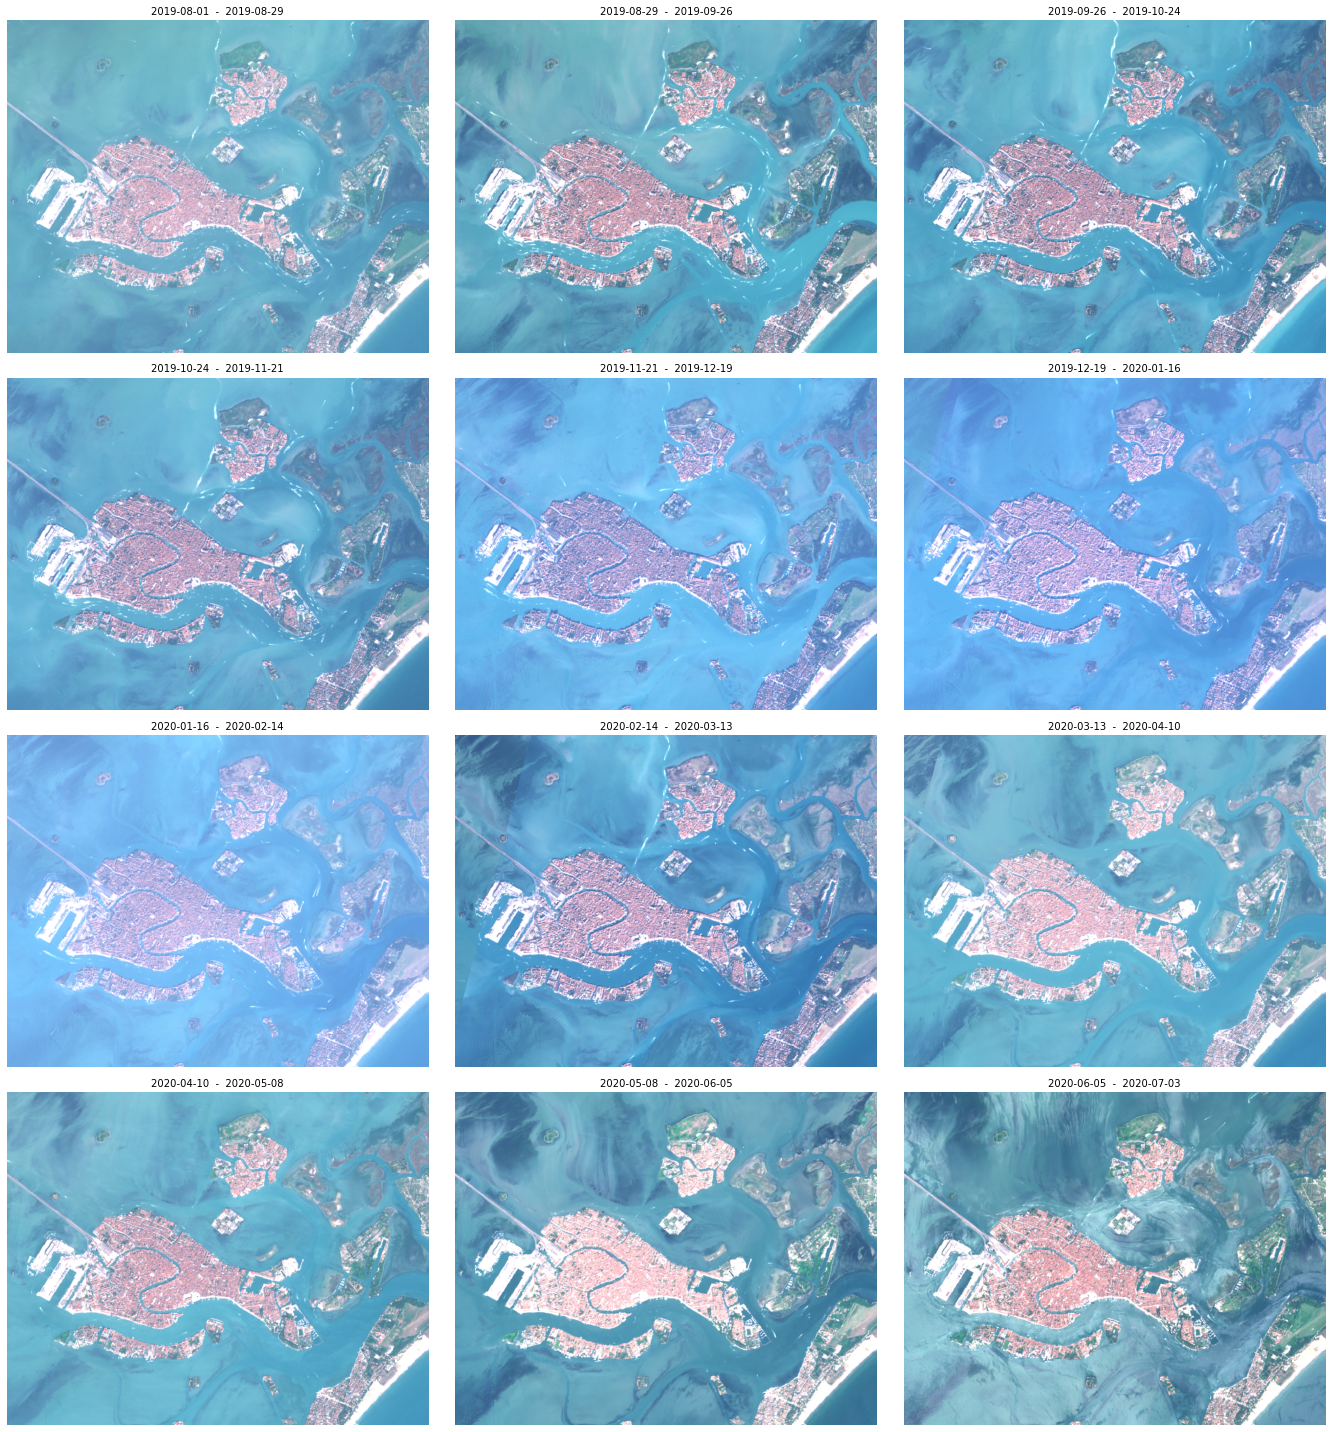

In [44]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)
# some stuff for pretty plots
ncols = 3
nrows = 4
aspect_ratio = venice_size[0] / venice_size[1]
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows),
                        subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5/255, 0, 1))
    ax.set_title(f'{slots[idx][0]}  -  {slots[idx][1]}', fontsize=10)

plt.tight_layout()

From the images we can see a reduction in the amount of activity which is occuring around the island of Venice. There also seems to be an impovement in the water qualty. We take this idea further by accuiring water qulaity measurments from JAXA. 

## Water Quality - JAXA

In [45]:
evalscript_jaxa = """
    //VERSION=3
    function setup() {
      return {
        input: ["tsm"],
        output: { bands: 1,
          sampleType: "UINT8" }
      };
    }
    function evaluatePixel(sample) {
        return [sample.tsm];
    }
    """

In [46]:
request_jaxa = SentinelHubRequest(
    evalscript=evalscript_jaxa,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc('4f5f67f1-5715-4f2b-8c98-ae57948ee2f5'),
            time_interval=('2020-03-15', '2020-04-15'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=adriatic_bbox,
    size=adriatic_size,
    config=config
)

In [47]:
jaxa = request_jaxa.get_data()

Image type: uint8


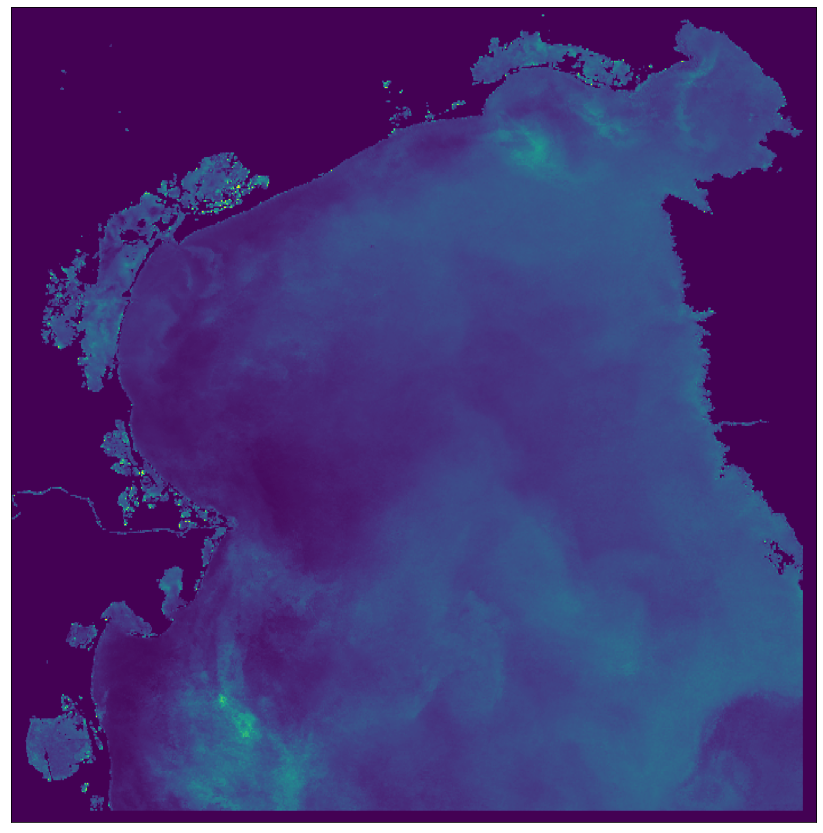

In [48]:
image = jaxa[0]
print(f'Image type: {image.dtype}')

# plot function
# byoc_data = request_vessels_pre.get_data()
plot_image(jaxa[0], factor=1 / 255)

In [49]:
def get_water_quality_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_jaxa,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.define_byoc('4f5f67f1-5715-4f2b-8c98-ae57948ee2f5'),
                time_interval=time_interval
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=adriatic_bbox,
        size=adriatic_size,
        config=config
    )

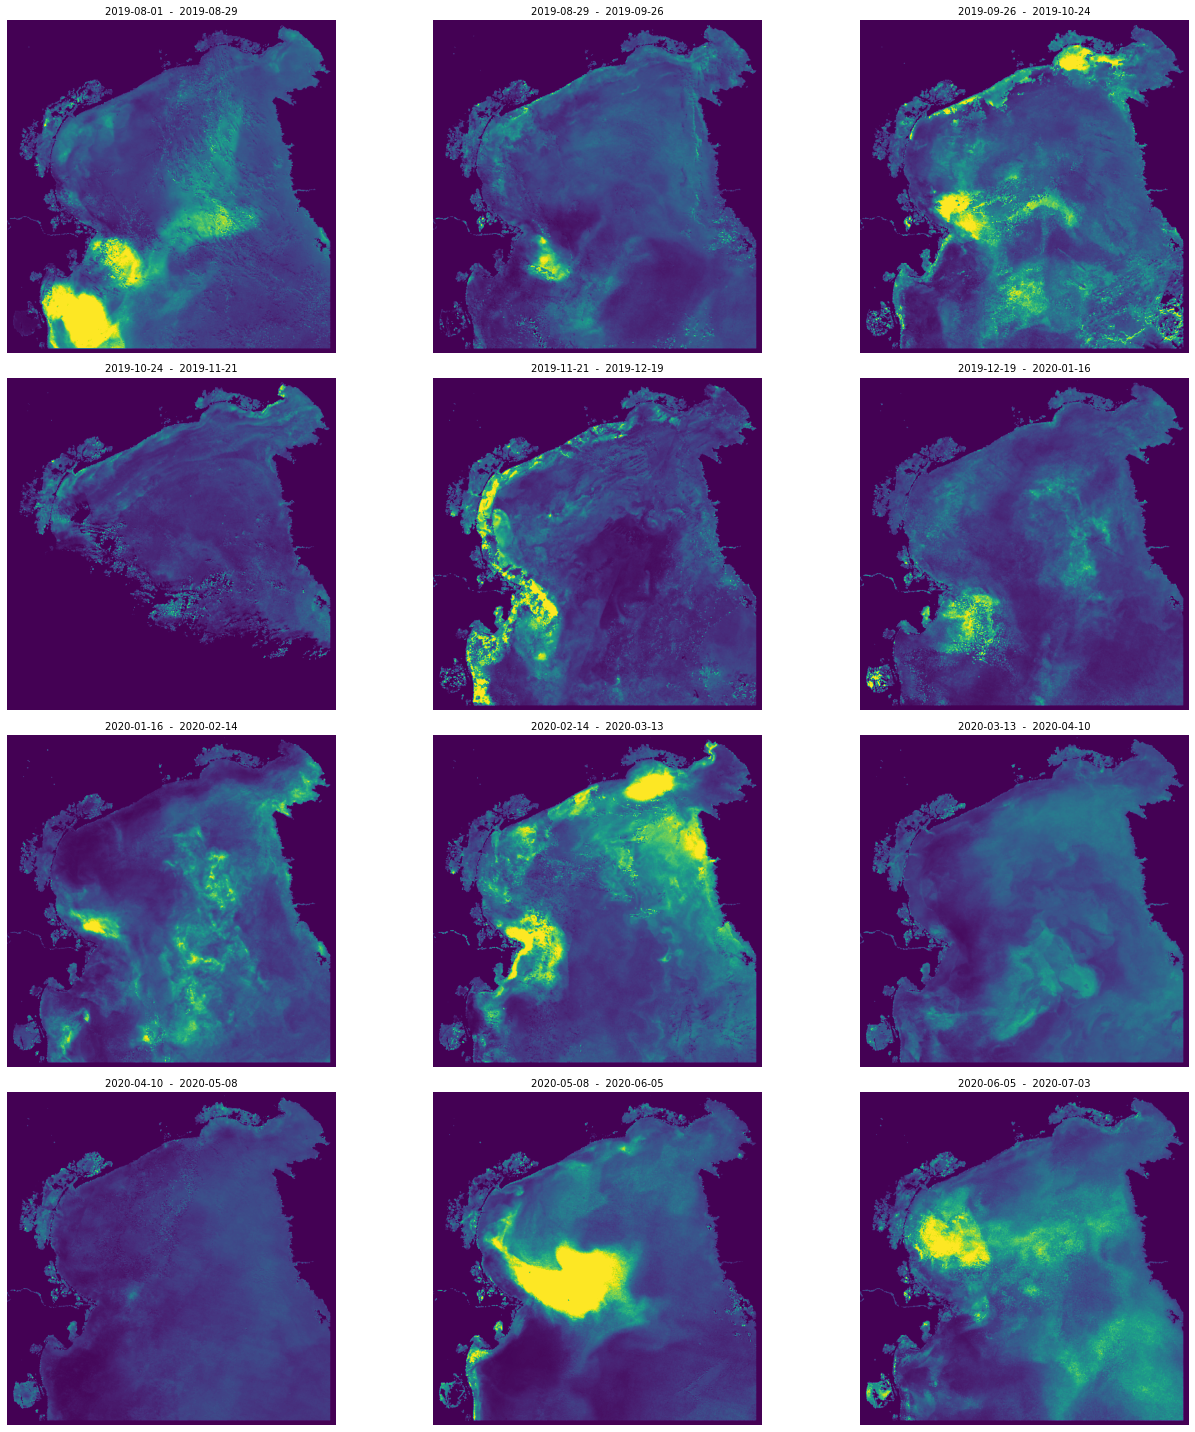

In [50]:
# create a list of requests
list_of_requests = [get_water_quality_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)
# some stuff for pretty plots
ncols = 3
nrows = 4
aspect_ratio = venice_size[0] / venice_size[1]
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows),
                        subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 1/255, 0, 1))
    ax.set_title(f'{slots[idx][0]}  -  {slots[idx][1]}', fontsize=10)

plt.tight_layout()

## Exersise

Can you retrieve a different [water quality product?](https://collections.eurodatacube.com/)

Can we see a pattern in the data? To make it clearer we will look at a timeseries of suspended matter taken by an insitu network stored in the geodb. 

## Retreiving water quality time series from GeoDB

In [51]:
geodb_database = "eodash"
geodb_collection = "N3"

In [52]:
data = geodb.get_collection(collection=geodb_collection, database=geodb_database)
data.head()

id                        created_at modified_at  \
0   1  2021-01-21T16:51:28.038108+00:00        None   
1   2  2021-01-21T16:51:28.038108+00:00        None   
2   3  2021-01-21T16:51:28.038108+00:00        None   
3   4  2021-01-21T16:51:28.038108+00:00        None   
4   5  2021-01-21T16:51:28.038108+00:00        None   

                    geometry                  aoi country              region  \
0  POINT (12.50806 45.31425)  45.314247,12.508055      IT  North Adriatic Sea   
1  POINT (12.50806 45.31425)  45.314247,12.508055      IT  North Adriatic Sea   
2  POINT (12.50806 45.31425)  45.314247,12.508055      IT  North Adriatic Sea   
3  POINT (12.50806 45.31425)  45.314247,12.508055      IT  North Adriatic Sea   
4  POINT (12.50806 45.31425)  45.314247,12.508055      IT  North Adriatic Sea   

            city                   site_name                description  ...  \
0  Venice Lagoon  AAOT fixed station Venezia  Water Quality Time Series  ...   
1  Venice Lagoon  AAOT fixed station Venezia  Water Quality Time Series  ...   
2  Venice Lagoon  AAOT fixed station Venezia  Water Quality Time Series  ...   
3  Venice Lagoon  AAOT fixed station Venezia  Water Quality Time Series  ...   
4  Venice Lagoon  AAOT fixed station Venezia  Water Quality Time Series  ...   

  reference_value                                               rule  \
0     [-999 -999]  Measurement < Reference [0] outputs LOW; Refer...   
1  [-0.139 0.044]  Measurement < Reference [0] outputs LOW; Refer...   
2  [-0.158 0.083]  Measurement < Reference [0] outputs LOW; Refer...   
3  [-0.138 0.099]  Measurement < Reference [0] outputs LOW; Refer...   
4  [-0.455 0.335]  Measurement < Reference [0] outputs LOW; Refer...   

  indicator_value sub_aoi                                y_axis  \
0               /       /  Chlorophyll-a concentration [mg m-3]   
1               /       /  Chlorophyll-a concentration [mg m-3]   
2          NORMAL       /  Chlorophyll-a concentration [mg m-3]   
3             LOW       /  Chlorophyll-a concentration [mg m-3]   
4             LOW       /  Chlorophyll-a concentration [mg m-3]   

                                      indicator_name color_code data_provider  \
0  Chlorophyll-a concentration at AAOT fixed stat...          /     CNR-ISMAR   
1  Chlorophyll-a concentration at AAOT fixed stat...          /     CNR-ISMAR   
2  Chlorophyll-a concentration at AAOT fixed stat...       BLUE     CNR-ISMAR   
3  Chlorophyll-a concentration at AAOT fixed stat...      GREEN     CNR-ISMAR   
4  Chlorophyll-a concentration at AAOT fixed stat...      GREEN     CNR-ISMAR   

  aoi_id update_frequency  
0    IT6           Weekly  
1    IT6           Weekly  
2    IT6           Weekly  
3    IT6           Weekly  
4    IT6           Weekly  

[5 rows x 28 columns]

In [53]:
import IPython.display
import json
import geopandas as gpd

cities = geodb.get_collection_pg(geodb_collection, database=geodb_database, group='city, geometry', select='city, geometry')

features = json.loads(cities.to_json())

IPython.display.GeoJSON(features)
    

<IPython.display.GeoJSON object>

In [54]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral3
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
output_notebook()

Loading BokehJS ...

In [55]:
def plot_city(city=cities.city[0]):
    #A bit hidden in this function lies the query against the RACE collection of interest.
    gdf = geodb.get_collection(geodb_collection, database=geodb_database, query=f"city=eq.{city}")
    
    # A bit if data cleaning to get this working as None values are given as '/'
    gdf = gdf.drop(gdf[gdf.indicator_value == "/"].index)
    
    indicator_values = geodb.get_collection_pg(geodb_collection, database=geodb_database, group='indicator_value', select='indicator_value')
    
    # A bit if data cleaning to get this working as None values are given as '/'
    indicator_values = indicator_values.drop(indicator_values[indicator_values.indicator_value == "/"].index)
    
    import pandas as pd
    gdf['time'] = pd.to_datetime(gdf.time)
    gdf['measurement_value']  = gdf.measurement_value.astype(float)
    source = ColumnDataSource(data=dict(time=gdf.time, measurement_value=gdf.measurement_value, indicator_value=gdf.indicator_value))
    
    p = figure(x_axis_type='datetime', width=1255)
    p.title.text = geodb_collection + " in " +  city
    p.title.align = "center"
    p.title.text_font_size = "25px"

    p.vbar(x='time', top='measurement_value', legend_field="indicator_value", line_width=4, fill_color=factor_cmap('indicator_value', palette=Spectral3, factors=indicator_values.indicator_value), line_color=factor_cmap('indicator_value', palette=Spectral3, factors=indicator_values.indicator_value), source=source)

    show(p)

Now we plot the cities with insitu water quality timeseries and select Venice as the city of interest with the dropdown menu.

In [58]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# Generate a unique list of cities
cities = geodb.get_collection_pg(geodb_collection, database=geodb_database, group='city', select='city')

interact(plot_city, city=cities.city);

interactive(children=(Dropdown(description='city', index=1, options=('Venice Lagoon', 'Barcelona', 'Marseilles…

The colours indicate if the water quality low, normal or good.